# Content Classification with Logistic Regression

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.utils import save_model, load_model

## Load Data

In [2]:
df_train = pd.read_csv("data/train.csv")
df_train.head()

,content,label
0,"Liputan6.com, London - Lee Dixon khawatir Arse...",bola
1,"Liputan6.com, Jakarta - Kasus dugaan penganiay...",news
2,"Liputan6.com, Jakarta Menanggapi aksi eks peke...",bisnis
3,"Liputan6.com, Medan - Sebanyak 81 kendaraan 4x...",bola
4,"Liputan6.com, Jakarta Indonesia akan melawan T...",bola


In [3]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,content,label
0,"Liputan6.com, Bandung Persib Bandung akan menj...",bola
1,"Liputan6.com, Jakarta - Mantan Ketua Mahkamah ...",news
2,"Liputan6.com, Cardiff - Tragedi yang menimpa E...",bola
3,"Liputan6.com, Jakarta - Kementerian Kelautan d...",bisnis
4,"Liputan6.com, Jakarta - PT Pertamina (Persero)...",bisnis


In [4]:
df_train.shape, df_test.shape

((6127, 2), (2627, 2))

Data train memiliki 6127 baris dan 2 kolom. Data test memiliki 2627 baris dan 2 kolom.

In [5]:
df_train.dtypes

content    object
label      object
dtype: object

In [6]:
df_test.dtypes

content    object
label      object
dtype: object

Baik train dan test tipe data telah sesuai.

In [7]:
df_train.isna().sum()

content    0
label      0
dtype: int64

In [8]:
df_test.isna().sum()

content    0
label      0
dtype: int64

Data telah bersih.

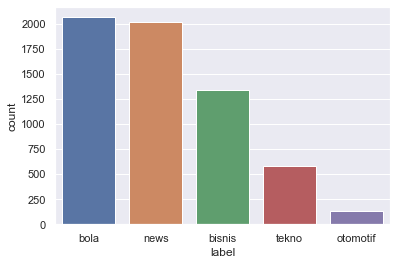

In [9]:
sns.countplot(df_train.label);

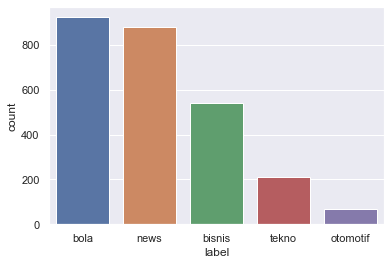

In [10]:
sns.countplot(df_test.label);

Data tidak balanbed.

In [11]:
df_train.content[0]

'Liputan6.com, London - Lee Dixon khawatir Arsenal tak bisa merekrut Denis Suarez secara permanen musim panas nanti. Pasalnya sejauh ini, Suarez hanya menjadi cadangan bagi The Gunners.\n\nSuarez dipinjam Arsenal dari Barcelona, Januari lalu. The Gunners juga bisa membelinya pada akhir musim nanti jika permainannya memuaskan.\n\nNamun sejauh ini Suarez tak menjadi pilihan utama di Arsenal. Manajer Unai Emery baru memberinya kesempatan bermain selama 85 menit.\n\n"Emery mungkin tahu kualitas Suarez. Dia tahu Suarez pemain yang dibutuhkannya," kata Dixon seperti dilansir Evening Standard.\n\n"Namun dari sudut pandang Suarez, dia pasti berpikir untuk apa pindah kalau tidak bermain. Jadi mungkin saja dia akan menolak Arsenal," katanya menambahkan.'

In [12]:
df_train.content[312]

'Jakarta Liga Champions 2018-2019 memasuki putaran 16 besar pada Selasa (12/2/2019) waktu setempat. Hasil mengejutkan terjadi setelah Manchester United menyerah dari Paris Saint-Germain.\n\nTidak tanggung-tanggung, Manchester United takluk dua gol tanpa balas saat menjamu Paris Saint-Germain. Padahal, Setan Merah lebih diunggulkan karena sedang dalam performa apik dan sang lawan juga tampil tanpa dua pemain terbaiknya, Neymar serta Edinson Cavani.\n\nMeski demikian, Angel di Maria menjadi aktor utama kemenangan Paris Saint-Germain. Mantan pemain Manchester United itu melepaskan dua umpan berujung gol kemenangan timnya yang dicetak Presnel Kimpembe dan Kylian Mbappe.\n\nHasil ini sangat menguntungkan Paris Saint-Germain untuk lolos ke perempat final. Sebab, pasukan Thomas Tuchel itu akan gantian menjamu Manchester United di Parc des Princes, Paris, 5 Maret mendatang.\n\nSementara itu pada laga lain, AS Roma membungkus kemenangan 2-1 atas FC Porto di Stadion Olimpico, Roma. Dua gol kemen

## Cleaning

In [13]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [14]:
stopwords = []
f = open('data/stopwords.txt', 'r')
for i in f.readlines():
    stopwords.append(i.replace('\n', ''))
sw_indo = stopwords + list(punctuation)

In [15]:
def cleansing(text):
    text = text.lower()
    word_list = word_tokenize(text)
    word_list = [word for word in word_list if len(word) > 1]
    word_list = [word for word in word_list if word not in sw_indo]
    text = ' '.join(word_list)
    return text

In [16]:
df_train['content'] = df_train.content.apply(cleansing)

In [17]:
df_test['content'] = df_test.content.apply(cleansing)

In [18]:
df_train.content[0]

'liputan6.com london lee dixon khawatir arsenal tak merekrut denis suarez permanen musim panas pasalnya sejauh suarez cadangan gunners suarez dipinjam arsenal barcelona januari gunners membelinya akhir musim permainannya memuaskan sejauh suarez tak pilihan utama arsenal manajer unai emery memberinya kesempatan bermain 85 menit emery mungkin tahu kualitas suarez tahu suarez pemain dibutuhkannya dixon dilansir evening standard sudut pandang suarez pasti berpikir pindah tidak bermain mungkin menolak arsenal katanya menambahkan'

In [19]:
df_train.content[312]

'jakarta liga champions 2018-2019 memasuki putaran 16 besar selasa 12/2/2019 waktu setempat hasil mengejutkan terjadi manchester united menyerah paris saint-germain tidak tanggung-tanggung manchester united takluk dua gol tanpa balas menjamu paris saint-germain padahal setan merah diunggulkan sedang performa apik sang lawan tampil tanpa dua pemain terbaiknya neymar serta edinson cavani meski demikian angel maria aktor utama kemenangan paris saint-germain mantan pemain manchester united melepaskan dua umpan berujung gol kemenangan timnya dicetak presnel kimpembe kylian mbappe hasil menguntungkan paris saint-germain lolos perempat final sebab pasukan thomas tuchel gantian menjamu manchester united parc des princes paris maret mendatang laga as roma membungkus kemenangan 2-1 fc porto stadion olimpico roma dua gol kemenangan lupi dicetak pemain muda nicolo zaniolo adapun satu-satunya gol fc porto dilesakkan adrian lopez meski kalah fc porto peluang lolos perempat final liga champions besar

In [20]:
df_train.head()

,content,label
0,liputan6.com london lee dixon khawatir arsenal...,bola
1,liputan6.com jakarta kasus dugaan penganiayaan...,news
2,liputan6.com jakarta menanggapi aksi eks peker...,bisnis
3,liputan6.com medan sebanyak 81 kendaraan 4x4 7...,bola
4,liputan6.com jakarta indonesia melawan thailan...,bola


In [21]:
df_test.head()

,content,label
0,liputan6.com bandung persib bandung menjalani ...,bola
1,liputan6.com jakarta mantan ketua mahkamah kon...,news
2,liputan6.com cardiff tragedi menimpa emiliano ...,bola
3,liputan6.com jakarta kementerian kelautan peri...,bisnis
4,liputan6.com jakarta pt pertamina persero petr...,bisnis


## Dataset Splitting

In [22]:
X_train = df_train.content
y_train = df_train.label
X_test = df_test.content
y_test = df_test.label

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6127,), (6127,), (2627,), (2627,))

## Modeling

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as sp

In [24]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])

model = RandomizedSearchCV(pipeline, sp.logreg_params, cv=5, scoring='f1_macro', n_iter=12, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:  2.6min finished


{'algo__fit_intercept': False, 'algo__C': 1000.0}
0.9921203347208838 0.9207073715263169 0.9273551670542257


## Tambahkan Class Weight

In [25]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])

parameter = {'algo__fit_intercept': [True, False],
             'algo__C': np.logspace(-3, 3, 7), 
             'algo__class_weight': [{'bola': 0.05, 'news': 0.05, 'bisnis': 0.05, 'tekno': 0.05, 'otomotif': 0.8},
                                   {'bola': 0.1, 'news': 0.1, 'bisnis': 0.1, 'tekno': 0.1, 'otomotif': 0.6}]}

model = RandomizedSearchCV(pipeline, parameter, cv=5, scoring='f1_macro', n_iter=12, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-2)]: Done  60 out of  60 | elapsed:  1.7min finished


{'algo__fit_intercept': False, 'algo__class_weight': {'bola': 0.05, 'news': 0.05, 'bisnis': 0.05, 'tekno': 0.05, 'otomotif': 0.8}, 'algo__C': 1000.0}
0.9921203347208838 0.9231361774466258 0.9262953983542914


Setelah ditambahkan class weight terjadi sedikit penurunan pada test.

## Fine Tuning

In [26]:
pipeline = Pipeline([
    ('prep', TfidfVectorizer()),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-2, random_state=42))
])

parameter = {'algo__fit_intercept': [True, False],
             'algo__C': [1000]}

model = RandomizedSearchCV(pipeline, parameter, cv=5, scoring='f1_macro', n_iter=12, n_jobs=-2, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  10 out of  10 | elapsed:   44.3s finished


{'algo__fit_intercept': False, 'algo__C': 1000}
0.9921203347208838 0.9207073715263169 0.9273551670542257


Model telah mendapatkan hyperparameter yang optimal.

## Evaluation

In [27]:
from sklearn.metrics import roc_auc_score
from jcopml.plot import plot_classification_report, plot_confusion_matrix

In [28]:
roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovr')

0.999718643285604

In [29]:
roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')

0.9932498467208417

In [30]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

      bisnis       1.00      0.99      0.99      1339
        bola       1.00      0.98      0.99      2063
        news       0.97      1.00      0.98      2017
    otomotif       1.00      0.99      1.00       130
       tekno       1.00      0.99      1.00       578

    accuracy                           0.99      6127
   macro avg       0.99      0.99      0.99      6127
weighted avg       0.99      0.99      0.99      6127


Test report
              precision    recall  f1-score   support

      bisnis       0.90      0.91      0.90       542
        bola       0.99      0.98      0.98       923
        news       0.92      0.94      0.93       880
    otomotif       0.95      0.84      0.89        70
       tekno       0.96      0.90      0.93       212

    accuracy                           0.94      2627
   macro avg       0.94      0.91      0.93      2627
weighted avg       0.94      0.94      0.94      26

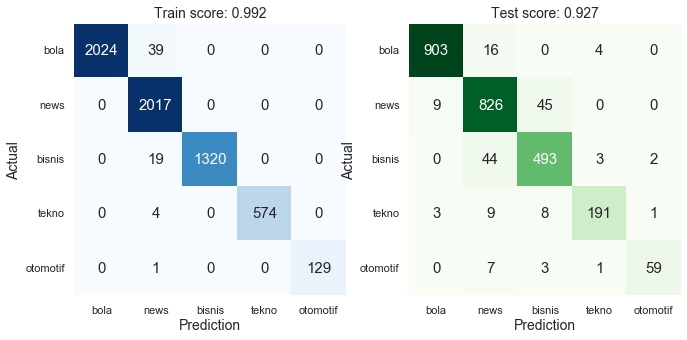

In [31]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

## Save Model

In [32]:
save_model(model.best_estimator_, "logreg.pkl")

Model is pickled as model/logreg.pkl


## Check 

In [33]:
text = '''Di Thailand, bengkel motor custom OK Easy Shop berhasil melahirkan street tracker mumpuni  dengan basis Interceptor 650. 
Secara konsep, ubahannya mengarah ke street tracker. Tapi, ada unsur scrambler yang dimasukkan, yakni pada bagian knalpotnya.'''

In [34]:
text = cleansing(text)

In [35]:
model.predict([text])

array(['otomotif'], dtype=object)

## Coba Cek Datanya!

In [36]:
df_analisis = pd.DataFrame(X_train.copy(), columns=['content'])
df_analisis['pred'] = model.predict(X_train)
df_analisis['actual'] = y_train.copy()
df_analisis.head()

,content,pred,actual
0,liputan6.com london lee dixon khawatir arsenal...,bola,bola
1,liputan6.com jakarta kasus dugaan penganiayaan...,news,news
2,liputan6.com jakarta menanggapi aksi eks peker...,bisnis,bisnis
3,liputan6.com medan sebanyak 81 kendaraan 4x4 7...,bola,bola
4,liputan6.com jakarta indonesia melawan thailan...,bola,bola


In [37]:
df_prec = df_analisis[(df_analisis.pred == 'news') & (df_analisis.actual == 'bisnis')]
df_prec

,content,pred,actual
351,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
713,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
969,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
982,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
1330,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
1515,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
1952,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
2240,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
2663,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis
3481,memasuki tahun kelima nestlé milo menggelar mi...,news,bisnis


Dari hasil analisis ternyata banyak data duplikat dan salah label.